I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
targets = pd.read_csv('./kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [3]:
%%time
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)        
        .clip(0, 1e8)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),

    
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col('text').fill_null('text_None')

]

df = (pl.read_parquet("./kaggle/input/game-play-train-parquet_pre_2/train.parquet")
      .with_columns(columns))
#       .drop(["fullscreen", "hq", "music"])

df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')


Wall time: 4.75 s


# elapsed_time_diff outleirs 제거

In [4]:
len(list(df1['text'].unique()))

99

In [5]:
list(df1['fqid'].unique())

['block_0',
 'block_tocollection',
 'block_tomap1',
 'block_tomap2',
 'boss',
 'chap1_finale',
 'chap1_finale_c',
 'cs',
 'directory',
 'doorblock',
 'gramps',
 'groupconvo',
 'intro',
 'janitor',
 'notebook',
 'outtolunch',
 'photo',
 'plaque',
 'plaque.face.date',
 'report',
 'retirement_letter',
 'teddy',
 'tobasement',
 'tocloset',
 'tocollection',
 'toentry',
 'togrampa',
 'tomap',
 'tostacks',
 'tunic',
 'tunic.capitol_0',
 'tunic.historicalsociety',
 'tunic.hub.slip',
 'tunic.kohlcenter',
 'wells',
 'fqid_None']

In [6]:
# len(room_lists)

In [7]:
# print(list(df['room_fqid'].unique()))

In [8]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

fqid_lists = ['archivist', 'archivist_glasses', 'block', 'block_0', 'block_1', 'block_badge', 'block_badge_2', 'block_magnify', 'block_nelson', 'block_tocollection', 'block_tomap1', 'block_tomap2', 'boss', 'businesscards', 'businesscards.card_0.next', 'businesscards.card_1.next', 'businesscards.card_bingo.bingo', 'businesscards.card_bingo.next', 'ch3start', 'chap1_finale', 'chap1_finale_c', 'chap2_finale', 'chap2_finale_c', 'chap4_finale_c', 'coffee', 'colorbook', 'confrontation', 'crane_ranger', 'cs', 'directory', 'directory.closeup.archivist', 'door_block_clean', 'door_block_talk', 'doorblock', 'expert', 'flag_girl', 'fox', 'glasses', 'gramps', 'groupconvo', 'groupconvo_flag', 'intro', 'janitor', 'journals', 'journals.hub.topics', 'journals.pic_0.next', 'journals.pic_1.next', 'journals.pic_2.bingo', 'journals.pic_2.next', 'journals_flag', 'journals_flag.hub.topics', 'journals_flag.hub.topics_old', 'journals_flag.pic_0.bingo', 'journals_flag.pic_0.next', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1.bingo', 'journals_flag.pic_1.next', 'journals_flag.pic_1_old.next', 'journals_flag.pic_2.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2_old.next', 'key', 'lockeddoor', 'logbook', 'logbook.page.bingo', 'magnify', 'need_glasses', 'notebook', 'outtolunch', 'photo', 'plaque', 'plaque.face.date', 'reader', 'reader.paper0.next', 'reader.paper0.prev', 'reader.paper1.next', 'reader.paper1.prev', 'reader.paper2.bingo', 'reader.paper2.next', 'reader.paper2.prev', 'reader_flag', 'reader_flag.paper0.next', 'reader_flag.paper0.prev', 'reader_flag.paper1.next', 'reader_flag.paper1.prev', 'reader_flag.paper2.bingo', 'reader_flag.paper2.next', 'reader_flag.paper2.prev', 'remove_cup', 'report', 'retirement_letter', 'savedteddy', 'seescratches', 'teddy', 'tobasement', 'tocage', 'tocloset', 'tocloset_dirty', 'tocollection', 'tocollectionflag', 'toentry', 'tofrontdesk', 'togrampa', 'tohallway', 'tomap', 'tomicrofiche', 'tostacks', 'tracks', 'tracks.hub.deer', 'trigger_coffee', 'trigger_scarf', 'tunic', 'tunic.capitol_0', 'tunic.capitol_1', 'tunic.capitol_2', 'tunic.drycleaner', 'tunic.flaghouse', 'tunic.historicalsociety', 'tunic.hub.slip', 'tunic.humanecology', 'tunic.kohlcenter', 'tunic.library', 'tunic.wildlife', 'unlockdoor', 'wells', 'wellsbadge', 'what_happened', 'worker']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

# level1_text_lists = ['A boring old shirt.', 'Besides, I already figured out the shirt.', 'Better check back later.', 'Can I come, Gramps?', 'Can I take a closer look?', 'Can we hurry up, Gramps?', 'Come on, Jo!', 'Could be. But we need evidence!', 'Did you do all of them?', 'Do I have to?', 'Find anything?', 'Found it!', 'Go ahead, take a peek at the shirt!', 'Grab your notebook and come upstairs!', 'Gramps is a great historian!', 'Gramps is in trouble for losing papers?', 'Gramps is the best historian ever!', 'Gramps said to look for clues. Better look around.', 'Ha. Told you so!', 'Hang tight, Teddy.', 'Have a look at the artifact!', 'Head over to the Basketball Center.', "Hey Jo, let's take a look at the shirt!", 'Hey!', "Hmm. Button's still not working.", "Hmmm. Don't forget about your homework.", "Hmmm. Shouldn't you be doing your homework?", 'Hooray, a boring old shirt.', 'Hopefully you can find some clues!', 'Hopefully you can rustle up some clues!', 'Hot Dog! I knew it!', "I feel like I'm forgetting something.", "I get to go to Gramps's meeting!", 'I gotta run to my meeting!', 'I knew it!', 'I love these photos of me and Teddy!', 'I need to get to the Capitol and tell Gramps!', 'I should go talk to Gramps!', 'I should see what Grampa is up to!', 'I should see what Gramps is up to!', 'I suppose historians are boring, too?', "I'll be at the Capitol. Let me know if you find anything!", "I'll hurry back and then we can go exploring!", "I'll record this in my notebook.", "I'm not so sure that this is a basketball jersey.", "It's a women's basketball jersey!", "It's already all done!", "It's true, they do keep going missing lately.", 'Just talking to Teddy.', 'Just this old slip from 1916.', "Leopold, why don't you help me set up in the Capitol?", "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!", "Look at that! It's the bee's knees!", "Meet me back in my office and we'll get started!", 'Meetings are BORING!', "No way, Gramps. You're the best!", 'No... because history is boring!', "Not Leopold here. He's been losing papers lately.", 'Now where did I put my notebook?', 'Ooh, I like clues!', 'Our shirt is too old to be a basketball jersey!', 'Plus, my teacher said I could help you out for extra credit!', 'See you later, Teddy.', 'See?', 'So? History is boring!', 'Sure thing, Jo. Grab your notebook and come upstairs!', 'Sure!', 'Teddy and I were gonna go climb that huge tree out back!', 'That settles it.', "That's it!", "The slip is from 1916 but the team didn't start until 1974!", 'Then do it for me!', 'This button never works!', "This can't be right!", 'This looks like a clue!', 'Ugh. Meetings are so boring.', 'Um... what did you want me to do again?', 'Wait, you mean Wells is wrong?!', 'We need to talk about that missing paperwork.', "Well, I did SOME of those. I just couldn't find them!", 'Well, Leopold here is always losing papers...', "Well, that's good enough for me.", 'Wells, finish up your report.', 'What a fascinating artifact!', 'Whatcha doing over there, Jo?', 'Who wants to investigate the shirt artifact?', "Why don't you go catch up with your grampa?", "Why don't you go play with your grampa?", "Why don't you head to the Basketball Center and rustle up some clues?", 'Will do, Boss.', "Wow, that's so cool, Gramps!", 'Yes! This cool old slip from 1916.', 'Yes! This old slip from 1916.', 'Your grampa is waiting for you in the collection room.', 'Your teacher said you could help me for extra credit.', 'Your teacher said you missed 7 assignments in a row!']
# level1_text_lists = ['A boring old shirt.', 'Besides, I already figured out the shirt.', 'Better check back later.', 'Can I come, Gramps?', 'Can I take a closer look?', 'Can we hurry up, Gramps?', 'Come on, Jo!', 'Could be. But we need evidence!', 'Did you do all of them?', 'Do I have to?', 'Find anything?', 'Found it!', 'Go ahead, take a peek at the shirt!', 'Grab your notebook and come upstairs!', 'Gramps is a great historian!', 'Gramps is in trouble for losing papers?', 'Gramps is the best historian ever!', 'Gramps said to look for clues. Better look around.', 'Ha. Told you so!', 'Hang tight, Teddy.', 'Have a look at the artifact!', 'Head over to the Basketball Center.', "Hey Jo, let's take a look at the shirt!", 'Hey!', "Hmm. Button's still not working.", "Hmmm. Don't forget about your homework.", "Hmmm. Shouldn't you be doing your homework?", 'Hooray, a boring old shirt.', 'Hopefully you can find some clues!', 'Hopefully you can rustle up some clues!', 'Hot Dog! I knew it!', "I feel like I'm forgetting something.", "I get to go to Gramps's meeting!", 'I gotta run to my meeting!', 'I knew it!', 'I love these photos of me and Teddy!', 'I need to get to the Capitol and tell Gramps!', 'I should go talk to Gramps!', 'I should see what Grampa is up to!', 'I should see what Gramps is up to!', 'I suppose historians are boring, too?', "I'll be at the Capitol. Let me know if you find anything!", "I'll hurry back and then we can go exploring!", "I'll record this in my notebook.", "I'm not so sure that this is a basketball jersey.", "It's a women's basketball jersey!", "It's already all done!", "It's true, they do keep going missing lately.", 'Just talking to Teddy.', 'Just this old slip from 1916.', "Leopold, why don't you help me set up in the Capitol?", "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!", "Look at that! It's the bee's knees!", "Meet me back in my office and we'll get started!", 'Meetings are BORING!', "No way, Gramps. You're the best!", 'No... because history is boring!', "Not Leopold here. He's been losing papers lately.", 'Now where did I put my notebook?', 'Ooh, I like clues!', 'Our shirt is too old to be a basketball jersey!', 'Plus, my teacher said I could help you out for extra credit!', 'See you later, Teddy.', 'See?', 'So? History is boring!', 'Sure thing, Jo. Grab your notebook and come upstairs!', 'Sure!', 'Teddy and I were gonna go climb that huge tree out back!', 'That settles it.', "That's it!", "The slip is from 1916 but the team didn't start until 1974!", 'Then do it for me!', 'This button never works!', "This can't be right!", 'This looks like a clue!', 'Ugh. Meetings are so boring.', 'Um... what did you want me to do again?', 'Wait, you mean Wells is wrong?!', 'We need to talk about that missing paperwork.', "Well, I did SOME of those. I just couldn't find them!", 'Well, Leopold here is always losing papers...', "Well, that's good enough for me.", 'Wells, finish up your report.', 'What a fascinating artifact!', 'Whatcha doing over there, Jo?', 'Who wants to investigate the shirt artifact?', "Why don't you go catch up with your grampa?", "Why don't you go play with your grampa?", "Why don't you head to the Basketball Center and rustle up some clues?", 'Will do, Boss.', "Wow, that's so cool, Gramps!", 'Yes! This cool old slip from 1916.', 'Yes! This old slip from 1916.', 'Your grampa is waiting for you in the collection room.', 'Your teacher said you could help me for extra credit.', 'Your teacher said you missed 7 assignments in a row!', '\\u00f0\\u0178\\u02dc\\u00b4']
# level1_text_lists = ["Hmm. Button's still not working.", 'Whatcha doing over there, Jo?', 'Come on, Jo!', "Meet me back in my office and we'll get started!", 'Ugh. Meetings are so boring.']

# best_F1_scores: 0.700135261005169, best_threshold_xgbs: 0.6250000000000002, best_feature_selection: ["Well, that's good enough for me.", 'So? History is boring!', "Why don't you head to the Basketball Center and rustle up some clues?", 'Yes! This old slip from 1916.', "The slip is from 1916 but the team didn't start until 1974!", 'We need to talk about that missing paperwork.', "I feel like I'm forgetting something.", 'Ooh, I like clues!', "It's already all done!", "Hey Jo, let's take a look at the shirt!", 'I should go talk to Gramps!', "Hmmm. Shouldn't you be doing your homework?", 'Our shirt is too old to be a basketball jersey!', 'Your teacher said you missed 7 assignments in a row!', "This can't be right!", 'Find anything?', 'See?', 'Gramps is in trouble for losing papers?', 'Then do it for me!', 'Will do, Boss.', 'Plus, my teacher said I could help you out for extra credit!', 'Yes! This cool old slip from 1916.', 'Found it!', 'Your teacher said you could help me for extra credit.', 'Teddy and I were gonna go climb that huge tree out back!', 'Sure thing, Jo. Grab your notebook and come upstairs!', 'Whatcha doing over there, Jo?', "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!", "Meet me back in my office and we'll get started!", 'Wells, finish up your report.', 'Sure!', 'See you later, Teddy.', 'A boring old shirt.', 'Meetings are BORING!', 'Now where did I put my notebook?', 'Ugh. Meetings are so boring.', 'Did you do all of them?', "I'll record this in my notebook.", 'Gramps is the best historian ever!', "I get to go to Gramps's meeting!", "Why don't you go play with your grampa?", 'I love these photos of me and Teddy!', "Why don't you go catch up with your grampa?", 'I suppose historians are boring, too?', 'Head over to the Basketball Center.', 'Can I come, Gramps?', 'Better check back later.', "Leopold, why don't you help me set up in the Capitol?", 'I gotta run to my meeting!', 'Just talking to Teddy.', 'Just this old slip from 1916.', '\\u00f0\\u0178\\u02dc\\u00b4', 'Gramps said to look for clues. Better look around.', "I'll be at the Capitol. Let me know if you find anything!", 'I should see what Grampa is up to!', 'Hooray, a boring old shirt.', 'Grab your notebook and come upstairs!', 'I need to get to the Capitol and tell Gramps!', "It's a women's basketball jersey!", 'What a fascinating artifact!', "Not Leopold here. He's been losing papers lately.", "Wow, that's so cool, Gramps!", 'Hot Dog! I knew it!', 'Have a look at the artifact!', "Hmmm. Don't forget about your homework.", 'No... because history is boring!', 'Do I have to?', 'Hey!', "Well, I did SOME of those. I just couldn't find them!", 'Hang tight, Teddy.', 'Besides, I already figured out the shirt.', 'Wait, you mean Wells is wrong?!', 'I should see what Gramps is up to!', "That's it!", 'Can we hurry up, Gramps?', "Look at that! It's the bee's knees!", "No way, Gramps. You're the best!", 'Gramps is a great historian!', 'Who wants to investigate the shirt artifact?', "Hmm. Button's still not working.", "It's true, they do keep going missing lately.", 'Your grampa is waiting for you in the collection room.', 'Go ahead, take a peek at the shirt!', 'Could be. But we need evidence!', "I'll hurry back and then we can go exploring!", 'Well, Leopold here is always losing papers...', 'This button never works!', 'Come on, Jo!', 'I knew it!', 'This looks like a clue!', 'Hopefully you can rustle up some clues!', 'That settles it.', 'Hopefully you can find some clues!', 'Can I take a closer look?', "I'm not so sure that this is a basketball jersey.", 'Ha. Told you so!']
level1_text_lists = ["Well, that's good enough for me.", 'So? History is boring!', "Why don't you head to the Basketball Center and rustle up some clues?", 'Yes! This old slip from 1916.', "The slip is from 1916 but the team didn't start until 1974!", 'We need to talk about that missing paperwork.', "I feel like I'm forgetting something.", 'Ooh, I like clues!', "It's already all done!", "Hey Jo, let's take a look at the shirt!", 'I should go talk to Gramps!', "Hmmm. Shouldn't you be doing your homework?", 'Our shirt is too old to be a basketball jersey!', 'Your teacher said you missed 7 assignments in a row!', "This can't be right!", 'Find anything?', 'See?', 'Gramps is in trouble for losing papers?', 'Then do it for me!', 'Will do, Boss.', 'Plus, my teacher said I could help you out for extra credit!', 'Yes! This cool old slip from 1916.', 'Found it!', 'Your teacher said you could help me for extra credit.', 'Teddy and I were gonna go climb that huge tree out back!', 'Sure thing, Jo. Grab your notebook and come upstairs!', 'Whatcha doing over there, Jo?', "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!", "Meet me back in my office and we'll get started!", 'Wells, finish up your report.', 'Sure!', 'See you later, Teddy.', 'A boring old shirt.', 'Meetings are BORING!', 'Now where did I put my notebook?', 'Ugh. Meetings are so boring.', 'Did you do all of them?', "I'll record this in my notebook.", 'Gramps is the best historian ever!', "I get to go to Gramps's meeting!", "Why don't you go play with your grampa?", 'I love these photos of me and Teddy!', "Why don't you go catch up with your grampa?", 'I suppose historians are boring, too?', 'Head over to the Basketball Center.', 'Can I come, Gramps?', 'Better check back later.', "Leopold, why don't you help me set up in the Capitol?", 'I gotta run to my meeting!', 'Just talking to Teddy.', 'Just this old slip from 1916.', '\\u00f0\\u0178\\u02dc\\u00b4', 'Gramps said to look for clues. Better look around.', "I'll be at the Capitol. Let me know if you find anything!", 'I should see what Grampa is up to!', 'Hooray, a boring old shirt.', 'Grab your notebook and come upstairs!', 'I need to get to the Capitol and tell Gramps!', "It's a women's basketball jersey!", 'What a fascinating artifact!', "Not Leopold here. He's been losing papers lately.", "Wow, that's so cool, Gramps!", 'Hot Dog! I knew it!', 'Have a look at the artifact!', "Hmmm. Don't forget about your homework.", 'No... because history is boring!', 'Do I have to?', 'Hey!', "Well, I did SOME of those. I just couldn't find them!", 'Hang tight, Teddy.', 'Besides, I already figured out the shirt.', 'Wait, you mean Wells is wrong?!', 'I should see what Gramps is up to!', "That's it!", 'Can we hurry up, Gramps?', "Look at that! It's the bee's knees!", "No way, Gramps. You're the best!", 'Gramps is a great historian!', 'Who wants to investigate the shirt artifact?', "Hmm. Button's still not working.", "It's true, they do keep going missing lately.", 'Your grampa is waiting for you in the collection room.', 'Go ahead, take a peek at the shirt!', 'Could be. But we need evidence!', "I'll hurry back and then we can go exploring!", 'Well, Leopold here is always losing papers...', 'This button never works!', 'Come on, Jo!', 'I knew it!', 'This looks like a clue!', 'Hopefully you can rustle up some clues!', 'That settles it.', 'Hopefully you can find some clues!', 'Can I take a closer look?', "I'm not so sure that this is a basketball jersey.", 'Ha. Told you so!']

# level2_text_lists = ['*COUGH COUGH COUGH*', '*cough cough*', '*grumble grumble*', 'A little horse!', 'AND I know who took Teddy!', 'AND he stole Teddy!', "Ah, that's better!", 'An old shirt? Try the university.', "And I'll figure out the shirt, too.", "And he messed up Gramps's office, too!", "And look! She's wearing the shirt!", "And where's your grampa?", 'And you are?', 'Are you okay?', 'BUT WELLS STOLE TEDDY!', 'Badgers? No.', 'Better check back later.', "But I hear the museum's got one on the loose!", 'But he never goes anywhere without his scarf!', 'But what if Wells kidnapped Teddy?', "Calm down, kid. I haven't seen him.", 'Can I give you the tour?', 'Can you help me find Wells?', 'Can you help me tidy up?', 'Can you help me-', 'Can you help me? I need to find Wells!', 'Can you help me? I need to find the owner of this slip.', 'Can you help-', "Can't believe I lost my reading glasses.", "Check out our microfiche. It's right through that door.", 'Could be. But we need evidence.', 'Did you drop something, Dear?', "Did you drop something, Dear? There's a card on the floor.", 'Did you figure out the shirt?', 'Did you have a question or not?', 'Did you have a question?', 'Do you have any info on Theodora Youmans?', 'Do you know anything about this slip?', 'Do you know what this slip is?', 'Do you know who Theodora Youmans is?', "Don't worry, Gramps. I'll find Teddy!", 'Easy, Jo.', "Fine. Let's investigate!", 'Go find your grampa and get to work!', 'Great! Thanks for the help!', "Guess it couldn't hurt to let you take a look.", 'Ha! Good one.', 'Ha! What do you call a pony with a sore throat?', "Ha! You're funny.", 'Have you seen a badger around here?', 'He needs our help!', 'He was looking for a taxidermist.', "He's always trying to get you in trouble, and he doesn't like animals!", "He's our expert record keeper.", "He's wrong about old shirts and his name rhymes with \\smells\\...", 'Head over to the university.', 'Head upstairs and talk to the archivist. He might be able to help!', 'Hello there!', 'Here I am!', "Here's a call number to find more info in the Stacks.", "Here's the log book.", 'Hey, this is Youmans!', 'Hi! *cough*', 'Hi! How can I help you?', 'Hi, Mrs. M.', "Hmm. Button's still not working.", "Hmmm... not sure. Why don't you try the library?", 'Hold your horses, Jo.', 'How can I help you?', 'Huh?', 'I bet the archivist could use this!', "I can't calm down. This is important!", "I don't have time for kids.", "I don't know!", "I don't need that right now.", 'I figured out that you kidnapped him!', 'I found it on an old shirt.', 'I found it!', 'I got here and the whole place was a mess!', 'I got here and the whole place was ransacked!', 'I got that one from my Gramps!', 'I had some cleaning up to do in my office.', 'I have an idea.', "I haven't quite figured it out just yet...", "I haven't seen him.", 'I hope you find your badger, kid.', 'I knew I could count on you, Jo!', 'I knew you could do it, Jo!', 'I love these photos of me and Teddy.', 'I need to find Wells right away! Do you know where he is?', 'I need to find Wells right away!! Do you know where he is?', 'I need to find Wells!!!', 'I need to find the owner of this slip.', 'I need your help!', 'I ran into Wells there this morning.', 'I should ask the librarian why Wells was here.', 'I should check that logbook to see who owned this slip...', 'I should find out if she can help me!', 'I should go to the Capitol and tell everyone!', 'I should help Gramps clean.', 'I should stay and look for clues!', "I think he's in trouble!", 'I used to have a magnifying glass around here\\u00e2\\u20ac\\u00a6', "I wonder if there's a clue in those business cards...", "I'm Leopold's grandkid!", "I'm afraid my papers have gone missing in this mess.", "I'm afraid not.", "I'm also looking for Theodora Youmans. Have you heard of her?", "I'm sure you'll find Theodora in there somewhere!", "I've got a stack of business cards from my favorite cleaners.", 'Is this your coffee, Gramps?', "It must've been Wells.", "It'll be okay, Jo. We'll find Teddy!", "It's a match!", "It's for Grampa Leo. He's a historian!", "It's our Norwegian Craft exhibit!", "It's such a nice fall day.", 'Jo, meet me back at my office.', "Jolie! I was hoping you'd stop by. Any news on the shirt artifact?", 'Knew what?', 'Leo... you mean Leopold?', 'Leopold, can you run back to the museum?', 'Looks like a dry cleaning receipt.', 'Maybe I can help!', 'Maybe he just got scared and ran off.', "Maybe there's a clue in this mess!", 'Mrs. M, I think Wells kidnapped Teddy.', 'Nice decorations.', 'Nice seeing you, Jolie!', 'Nice work on the shirt, Jolie!', "Nope, that's from Bean Town. I only drink Holdgers!", 'Nope. But Youmans and other suffragists worked hard to change that.', 'Not sure. Here, let me look it up.', 'Now I Just need to find all the cleaners from way back in 1916.', 'Now I just need to find all the cleaners from wayyyy back in 1916.', 'Now can I tell you what happened to Teddy?', 'Now if only I could read this thing.', 'Now if only I could read this thing. Blasted tiny letters...', 'Oh my!', 'Oh no!', 'Oh no... Teddy!', "Oh, I'm fine! Just a little hoarse.", 'Oh, hello there!', "Oh, that's from Bean Town.", "Okay. I'll find Teddy!", 'Okay. Thanks anyway.', 'One step at a time, Jo.', 'Ooh, nice decorations!', 'Ooh, thanks!', 'Please let me know if you do.', "Please let me know if you do. It's important!", 'Please?', 'Please? This is really important.', "Poor Gramps! I should make sure he's okay.", 'Right outside the door.', 'Run along to the university.', 'She helped get votes for women!', 'She led marches and helped women get the right to vote!', 'Slow down, Jo.', 'So much cleaning to do...', "Sorry I'm late.", 'Sorry for the delay, Boss.', "Sorry, I'm in a hurry.", "Sorry, I'm too busy for kids right now.", "Sorry, can't help you.", 'Sounds good, Boss.', 'Take a look!', "Teddy's scarf! Somebody must've taken him!", 'Thanks for the help!', 'Thanks to them, Wisconsin was the first state to approve votes for women!', 'Thanks.', 'Thanks. Did you figure out the shirt?', 'The archivist said I should look in the stacks.', 'The libarian said I could find some information on Youmans in here...', 'Then we need evidence.', 'Theodora Youmans must be the owner!', 'Theodora Youmans? Is that who owned the shirt?', 'Theodora Youmans? Of course!', 'Theodora wearing the shirt!', 'They study clothes and fabric.', 'This button never works!', 'This place was around in 1916! I can start there!', 'Try not to panic, Jo.', 'Two missions, actually!', 'Ugh. Fine.', 'Um, are you okay?', "Unless you're too busy horsing around.", 'Wait a minute!', "Wait a sec. Women couldn't vote?!", 'Welcome back, Jolie. Did you figure out the shirt?', "Well, I can't show our log books to just anybody.", "Well, get on it. I'm counting on you and your gramps to figure this out!", 'Well? What are you still doing here?', 'Wells sabotaged Gramps!', 'Wells! What was he doing here? I should ask the librarian.', "Wells! Where's Teddy? Is he okay?", 'Wells? I knew it!', "Weren't you going to check out our microfiche?", 'What are you still doing here,  Jolie?', 'What are you waiting for? The Stacks are right outside the door.', 'What happened here?!', 'What should I do first?', 'What the-', 'What was Wells doing here?', "What's a taxidermist?", "What's a textile expert?", 'Where are the Stacks?', 'Where did you get that coffee?', 'Where should I go again?', 'Who are you?', "Who could've done this?", 'Who is Teddy?', "Why didn't you say so?", "Why don't you go upstairs and see the archivist?", "Why don't you prove your case?", "Why don't you take a look?", 'Wow!', 'Wow! What is all this stuff?', 'Yeah. Thanks anyway.', 'Yep.', 'Yes!', 'Yes! I was wondering-', 'Yikes... this could take a while.', 'You better get to the capitol!', 'You can talk to a textile expert there.', 'You could ask the archivist. He knows everybody!', 'You could try the archivist. Maybe he can help you find Wells!', "You haven't seen any badgers around here, have you?", "You look like you're on a mission.", "You'll have to get started without me.", "You're right, Gramps. Let's investigate!", "You're still here? I'm trying to work!", 'Youmans was a suffragist here in Wisconsin.', 'Youmans was a suffragist!', 'Your gramps is awesome! Always full of stories.', "Yup, that's him!", '\\Taxidermy: the art of preparing, stuffing, and mounting the skins of animals.\\']
level2_text_lists = ['*COUGH COUGH COUGH*', '*cough cough*', '*grumble grumble*', 'A little horse!', 'AND I know who took Teddy!', 'AND he stole Teddy!', "Ah, that's better!", 'An old shirt? Try the university.', "And I'll figure out the shirt, too.", "And he messed up Gramps's office, too!", "And look! She's wearing the shirt!", "And where's your grampa?", 'And you are?', 'Are you okay?', 'BUT WELLS STOLE TEDDY!', 'Badgers? No.', 'Better check back later.', "But I hear the museum's got one on the loose!", 'But he never goes anywhere without his scarf!', 'But what if Wells kidnapped Teddy?', "Calm down, kid. I haven't seen him.", 'Can I give you the tour?', 'Can you help me find Wells?', 'Can you help me tidy up?', 'Can you help me-', 'Can you help me? I need to find Wells!', 'Can you help me? I need to find the owner of this slip.', 'Can you help-', "Can't believe I lost my reading glasses.", "Check out our microfiche. It's right through that door.", 'Could be. But we need evidence.', 'Did you drop something, Dear?', "Did you drop something, Dear? There's a card on the floor.", 'Did you figure out the shirt?', 'Did you have a question or not?', 'Did you have a question?', 'Do you have any info on Theodora Youmans?', 'Do you know anything about this slip?', 'Do you know what this slip is?', 'Do you know who Theodora Youmans is?', "Don't worry, Gramps. I'll find Teddy!", 'Easy, Jo.', "Fine. Let's investigate!", 'Go find your grampa and get to work!', 'Great! Thanks for the help!', "Guess it couldn't hurt to let you take a look.", 'Ha! Good one.', 'Ha! What do you call a pony with a sore throat?', "Ha! You're funny.", 'Have you seen a badger around here?', 'He needs our help!', 'He was looking for a taxidermist.', "He's always trying to get you in trouble, and he doesn't like animals!", "He's our expert record keeper.", "He's wrong about old shirts and his name rhymes with \\smells\\...", 'Head over to the university.', 'Head upstairs and talk to the archivist. He might be able to help!', 'Hello there!', 'Here I am!', "Here's a call number to find more info in the Stacks.", "Here's the log book.", 'Hey, this is Youmans!', 'Hi! *cough*', 'Hi! How can I help you?', 'Hi, Mrs. M.', "Hmm. Button's still not working.", "Hmmm... not sure. Why don't you try the library?", 'Hold your horses, Jo.', 'How can I help you?', 'Huh?', 'I bet the archivist could use this!', "I can't calm down. This is important!", "I don't have time for kids.", "I don't know!", "I don't need that right now.", 'I figured out that you kidnapped him!', 'I found it on an old shirt.', 'I found it!', 'I got here and the whole place was a mess!', 'I got here and the whole place was ransacked!', 'I got that one from my Gramps!', 'I had some cleaning up to do in my office.', 'I have an idea.', "I haven't quite figured it out just yet...", "I haven't seen him.", 'I hope you find your badger, kid.', 'I knew I could count on you, Jo!', 'I knew you could do it, Jo!', 'I love these photos of me and Teddy.', 'I need to find Wells right away! Do you know where he is?', 'I need to find Wells right away!! Do you know where he is?', 'I need to find Wells!!!', 'I need to find the owner of this slip.', 'I need your help!', 'I ran into Wells there this morning.', 'I should ask the librarian why Wells was here.', 'I should check that logbook to see who owned this slip...', 'I should find out if she can help me!', 'I should go to the Capitol and tell everyone!', 'I should help Gramps clean.', 'I should stay and look for clues!', "I think he's in trouble!", 'I used to have a magnifying glass around here\\u00e2\\u20ac\\u00a6', "I wonder if there's a clue in those business cards...", "I'm Leopold's grandkid!", "I'm afraid my papers have gone missing in this mess.", "I'm afraid not.", "I'm also looking for Theodora Youmans. Have you heard of her?", "I'm sure you'll find Theodora in there somewhere!", "I've got a stack of business cards from my favorite cleaners.", 'Is this your coffee, Gramps?', "It must've been Wells.", "It'll be okay, Jo. We'll find Teddy!", "It's a match!", "It's for Grampa Leo. He's a historian!", "It's our Norwegian Craft exhibit!", "It's such a nice fall day.", 'Jo, meet me back at my office.', "Jolie! I was hoping you'd stop by. Any news on the shirt artifact?", 'Knew what?', 'Leo... you mean Leopold?', 'Leopold, can you run back to the museum?', 'Looks like a dry cleaning receipt.', 'Maybe I can help!', 'Maybe he just got scared and ran off.', "Maybe there's a clue in this mess!", 'Mrs. M, I think Wells kidnapped Teddy.', 'Nice decorations.', 'Nice seeing you, Jolie!', 'Nice work on the shirt, Jolie!', "Nope, that's from Bean Town. I only drink Holdgers!", 'Nope. But Youmans and other suffragists worked hard to change that.', 'Not sure. Here, let me look it up.', 'Now I Just need to find all the cleaners from way back in 1916.', 'Now I just need to find all the cleaners from wayyyy back in 1916.', 'Now can I tell you what happened to Teddy?', 'Now if only I could read this thing.', 'Now if only I could read this thing. Blasted tiny letters...', 'Oh my!', 'Oh no!', 'Oh no... Teddy!', "Oh, I'm fine! Just a little hoarse.", 'Oh, hello there!', "Oh, that's from Bean Town.", "Okay. I'll find Teddy!", 'Okay. Thanks anyway.', 'One step at a time, Jo.', 'Ooh, nice decorations!', 'Ooh, thanks!', 'Please let me know if you do.', "Please let me know if you do. It's important!", 'Please?', 'Please? This is really important.', "Poor Gramps! I should make sure he's okay.", 'Right outside the door.', 'Run along to the university.', 'She helped get votes for women!', 'She led marches and helped women get the right to vote!', 'Slow down, Jo.', 'So much cleaning to do...', "Sorry I'm late.", 'Sorry for the delay, Boss.', "Sorry, I'm in a hurry.", "Sorry, I'm too busy for kids right now.", "Sorry, can't help you.", 'Sounds good, Boss.', 'Take a look!', "Teddy's scarf! Somebody must've taken him!", 'Thanks for the help!', 'Thanks to them, Wisconsin was the first state to approve votes for women!', 'Thanks.', 'Thanks. Did you figure out the shirt?', 'The archivist said I should look in the stacks.', 'The libarian said I could find some information on Youmans in here...', 'Then we need evidence.', 'Theodora Youmans must be the owner!', 'Theodora Youmans? Is that who owned the shirt?', 'Theodora Youmans? Of course!', 'Theodora wearing the shirt!', 'They study clothes and fabric.', 'This button never works!', 'This place was around in 1916! I can start there!', 'Try not to panic, Jo.', 'Two missions, actually!', 'Ugh. Fine.', 'Um, are you okay?', "Unless you're too busy horsing around.", 'Wait a minute!', "Wait a sec. Women couldn't vote?!", 'Welcome back, Jolie. Did you figure out the shirt?', "Well, I can't show our log books to just anybody.", "Well, get on it. I'm counting on you and your gramps to figure this out!", 'Well? What are you still doing here?', 'Wells sabotaged Gramps!', 'Wells! What was he doing here? I should ask the librarian.', "Wells! Where's Teddy? Is he okay?", 'Wells? I knew it!', "Weren't you going to check out our microfiche?", 'What are you still doing here,  Jolie?', 'What are you waiting for? The Stacks are right outside the door.', 'What happened here?!', 'What should I do first?', 'What the-', 'What was Wells doing here?', "What's a taxidermist?", "What's a textile expert?", 'Where are the Stacks?', 'Where did you get that coffee?', 'Where should I go again?', 'Who are you?', "Who could've done this?", 'Who is Teddy?', "Why didn't you say so?", "Why don't you go upstairs and see the archivist?", "Why don't you prove your case?", "Why don't you take a look?", 'Wow!', 'Wow! What is all this stuff?', 'Yeah. Thanks anyway.', 'Yep.', 'Yes!', 'Yes! I was wondering-', 'Yikes... this could take a while.', 'You better get to the capitol!', 'You can talk to a textile expert there.', 'You could ask the archivist. He knows everybody!', 'You could try the archivist. Maybe he can help you find Wells!', "You haven't seen any badgers around here, have you?", "You look like you're on a mission.", "You'll have to get started without me.", "You're right, Gramps. Let's investigate!", "You're still here? I'm trying to work!", 'Youmans was a suffragist here in Wisconsin.', 'Youmans was a suffragist!', 'Your gramps is awesome! Always full of stories.', "Yup, that's him!", '\\Taxidermy: the art of preparing, stuffing, and mounting the skins of animals.\\']


PAGES = [0, 1, 2, 3, 4, 5, 6]

In [9]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),        
        
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        
        *[pl.col(c).quantile(0.1, "nearest").alias(f"{c}_quantile1_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.2, "nearest").alias(f"{c}_quantile2_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.4, "nearest").alias(f"{c}_quantile4_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.6, "nearest").alias(f"{c}_quantile6_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.8, "nearest").alias(f"{c}_quantile8_{feature_suffix}") for c in NUMS],
        *[pl.col(c).quantile(0.9, "nearest").alias(f"{c}_quantile9_{feature_suffix}") for c in NUMS],
        
        

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in fqid_lists],

        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}")
          for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        
        

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).median().alias(
            f"{c}_ET_median_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c
          in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        
        *[pl.col("page").filter(pl.col("page") == c).count().alias(f"{c}_page_count{feature_suffix}") for c in
          PAGES],
        *[pl.col("elapsed_time_diff").filter(pl.col("page") == c).std().alias(f"{c}_page_std_{feature_suffix}") for c in
          PAGES],
        *[pl.col("elapsed_time_diff").filter(pl.col("page") == c).mean().alias(f"{c}_page_mean_{feature_suffix}") for c
          in PAGES],
        *[pl.col("elapsed_time_diff").filter(pl.col("page") == c).sum().alias(f"{c}_page_sum_{feature_suffix}") for c in
          PAGES],
        *[pl.col("elapsed_time_diff").filter(pl.col("page") == c).median().alias(f"{c}_page_median_{feature_suffix}") for
          c in PAGES],
        *[pl.col("elapsed_time_diff").filter(pl.col("page") == c).max().alias(f"{c}_page_max_{feature_suffix}") for c in
          PAGES],
        

        

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(
            f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).median().alias(
            f"{c}_ET_median_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in
          level_groups],
        
        
        *[pl.col("text").filter(pl.col("text") == c).count().alias(f"{c}_level1_text_counts{feature_suffix}") for c in level1_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).std().alias(f"{c}_level1_text_ET_std_{feature_suffix}") for c in level1_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).mean().alias(f"{c}_level1_text_ET_mean_{feature_suffix}") for c in level1_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).sum().alias(f"{c}_level1_text_ET_sum_{feature_suffix}") for c in level1_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).median().alias(f"{c}_level1_text_ET_median_{feature_suffix}") for c in level1_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).max().alias(f"{c}_level1_text_ET_max_{feature_suffix}") for c in level1_text_lists],
        
        
        *[pl.col("text").filter(pl.col("text") == c).count().alias(f"{c}_level2_text_counts{feature_suffix}") for c in level2_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).std().alias(f"{c}_level2_text_ET_std_{feature_suffix}") for c in level2_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).mean().alias(f"{c}_level2_text_ET_mean_{feature_suffix}") for c in level2_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).sum().alias(f"{c}_level2_text_ET_sum_{feature_suffix}") for c in level2_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).median().alias(f"{c}_level2_text_ET_median_{feature_suffix}") for c in level2_text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text") == c).max().alias(f"{c}_level2_text_ET_max_{feature_suffix}") for c in level2_text_lists],
        
        
    

    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text") == "Here's the log book.")
                                              | (pl.col("fqid") == 'logbook.page.bingo'))
                    .apply(lambda s: s.max() - s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                        pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                        pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
                
                
               (pl.col('index').filter((pl.col('fqid')=='logbook.page.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('index').filter((pl.col('fqid')=='logbook')).first()).alias('logbingo-logbook_first'), # Not Working
               
                
                # (pl.col('elapsed_time').filter((pl.col('fqid')=='logbook.page.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('elapsed_time').filter((pl.col('fqid')=='logbook')).first()).alias('logbingo-logbook_time_first'), # wroking                                
                                        
               # readerbingo-reader first feature (index, elapsed_time)
#                (pl.col('index').filter((pl.col('fqid')=='reader.paper2.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('index').filter((pl.col('fqid')=='reader')).first()).alias('readerbingo-reader_first'),
#                (pl.col('elapsed_time').filter((pl.col('fqid')=='reader.paper2.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('elapsed_time').filter((pl.col('fqid')=='reader')).first()).alias('readerbingo-reader_time_first'),
                
                # jourbingo first feature (index, elapsed_time)
#                 (pl.col('index').filter((pl.col('fqid')=='journals.pic_2.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('index').filter((pl.col('fqid')=='journals.pic_0.next')).first()).alias('jourbingo-journalspic_first'),
#                 (pl.col('elapsed_time').filter((pl.col('fqid')=='journals.pic_2.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('elapsed_time').filter((pl.col('fqid')=='journals.pic_0.next')).first()).alias('jourbingo-journalspic_time_first'),
                
                # logbook last feature (index, elapsed_time)                            
                # (pl.col('index').filter((pl.col('fqid')=='logbook.page.bingo') & (pl.col('event_name')=='object_click')).last() - pl.col('index').filter((pl.col('fqid')=='logbook')).last()).alias('logbingo-logbook_last'), # Not Working
                # (pl.col('elapsed_time').filter((pl.col('fqid')=='logbook.page.bingo') & (pl.col('event_name')=='object_click')).last() - pl.col('elapsed_time').filter((pl.col('fqid')=='logbook')).last()).alias('logbingo-logbook_time_last'), # wroking
                
                # readerbingo-reader last feature (index, elapsed_time)
                # (pl.col('index').filter((pl.col('fqid')=='reader.paper2.bingo') & (pl.col('event_name')=='object_click')).last() - pl.col('index').filter((pl.col('fqid')=='reader')).last()).alias('readerbingo-reader_last'),
                # (pl.col('elapsed_time').filter((pl.col('fqid')=='reader.paper2.bingo') & (pl.col('event_name')=='object_click')).last() - pl.col('elapsed_time').filter((pl.col('fqid')=='reader')).last()).alias('readerbingo-reader_time_last'),
                
                # jourbingo last feature (index, elapsed_time)
                # (pl.col('index').filter((pl.col('fqid')=='journals.pic_2.bingo') & (pl.col('event_name')=='object_click')).last() - pl.col('index').filter((pl.col('fqid')=='journals.pic_0.next')).last()).alias('jourbingo-journalspic_last'),
                # (pl.col('elapsed_time').filter((pl.col('fqid')=='journals.pic_2.bingo') & (pl.col('event_name')=='object_click')).first() - pl.col('elapsed_time').filter((pl.col('fqid')=='journals.pic_0.next')).first()).alias('jourbingo-journalspic_time_first'),
                
                # logbook first feature (index, elapsed_time)                            
                # (pl.col('index').filter((pl.col('fqid')=='logbook.page.bingo') & (pl.col('event_name')=='object_hover')).first() - pl.col('index').filter((pl.col('fqid')=='logbook')).first()).alias('logbingo-logbook_oh_first'), # Not Working
                # (pl.col('elapsed_time').filter((pl.col('fqid')=='logbook.page.bingo') & (pl.col('event_name')=='object_hover')).first() - pl.col('elapsed_time').filter((pl.col('fqid')=='logbook')).first()).alias('logbingo-logbook_time_oh_first'), # wroking                                
                
                # readerbingo-reader first feature (index, elapsed_time)
                # (pl.col('index').filter((pl.col('fqid')=='reader.paper2.bingo') & (pl.col('event_name')=='object_hover')).first() - pl.col('index').filter((pl.col('fqid')=='reader')).first()).alias('readerbingo-reader_ho_first'),
                # (pl.col('elapsed_time').filter((pl.col('fqid')=='reader.paper2.bingo') & (pl.col('event_name')=='object_hover')).first() - pl.col('elapsed_time').filter((pl.col('fqid')=='reader')).first()).alias('readerbingo-reader_time_ho_first'),
                
            ]            
                
#             # logbook first feature (index, elapsed_time)                            

            
            
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [10]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
# df1 = time_feature(df1) # Not working
print('df1 done')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
# df2 = time_feature(df2) # Not working
print('df2 done')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
# df3 = time_feature(df3) # Not working
print('df3 done')

df1 done
df2 done
df3 done
Wall time: 32.6 s


In [11]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

2415 1630 2430


  0%|          | 0/4014 [00:00<?, ?it/s]

elapsed_time_diff_min_
archivist_fqid_counts
archivist_glasses_fqid_counts
block_fqid_counts
block_1_fqid_counts
block_badge_fqid_counts
block_badge_2_fqid_counts
block_magnify_fqid_counts
block_nelson_fqid_counts
businesscards_fqid_counts
businesscards.card_0.next_fqid_counts
businesscards.card_1.next_fqid_counts
businesscards.card_bingo.bingo_fqid_counts
businesscards.card_bingo.next_fqid_counts
ch3start_fqid_counts
chap2_finale_fqid_counts
chap2_finale_c_fqid_counts
chap4_finale_c_fqid_counts
coffee_fqid_counts
colorbook_fqid_counts
confrontation_fqid_counts
crane_ranger_fqid_counts
directory.closeup.archivist_fqid_counts
door_block_clean_fqid_counts
door_block_talk_fqid_counts
expert_fqid_counts
flag_girl_fqid_counts
fox_fqid_counts
glasses_fqid_counts
groupconvo_flag_fqid_counts
journals_fqid_counts
journals.hub.topics_fqid_counts
journals.pic_0.next_fqid_counts
journals.pic_1.next_fqid_counts
journals.pic_2.bingo_fqid_counts
journals.pic_2.next_fqid_counts
journals_flag_fqid_coun

5_LEVEL_count
6_LEVEL_count
7_LEVEL_count
8_LEVEL_count
9_LEVEL_count
10_LEVEL_count
11_LEVEL_count
12_LEVEL_count
13_LEVEL_count
14_LEVEL_count
15_LEVEL_count
16_LEVEL_count
17_LEVEL_count
18_LEVEL_count
19_LEVEL_count
20_LEVEL_count
21_LEVEL_count
22_LEVEL_count
2_page_count
3_page_count
4_page_count
5_page_count
6_page_count
5-12_LEVEL_group_count
13-22_LEVEL_group_count
Meet me back in my office and we'll get started!_level1_text_ET_std_
Come on, Jo!_level1_text_ET_std_
*COUGH COUGH COUGH*_level2_text_counts
*cough cough*_level2_text_counts
*grumble grumble*_level2_text_counts
A little horse!_level2_text_counts
AND I know who took Teddy!_level2_text_counts
AND he stole Teddy!_level2_text_counts
Ah, that's better!_level2_text_counts
An old shirt? Try the university._level2_text_counts
And I'll figure out the shirt, too._level2_text_counts
And he messed up Gramps's office, too!_level2_text_counts
And look! She's wearing the shirt!_level2_text_counts
And where's your grampa?_level2_te

*********df1 DONE*********


  0%|          | 0/4021 [00:00<?, ?it/s]

elapsed_time_diff_min_
archivist_glasses_fqid_counts
block_nelson_fqid_counts
block_tocollection_fqid_counts
block_tomap1_fqid_counts
block_tomap2_fqid_counts
ch3start_fqid_counts
chap1_finale_fqid_counts
chap1_finale_c_fqid_counts
chap4_finale_c_fqid_counts
coffee_fqid_counts
colorbook_fqid_counts
confrontation_fqid_counts
crane_ranger_fqid_counts
cs_fqid_counts
directory.closeup.archivist_fqid_counts
doorblock_fqid_counts
expert_fqid_counts
flag_girl_fqid_counts
fox_fqid_counts
glasses_fqid_counts
groupconvo_fqid_counts
groupconvo_flag_fqid_counts
intro_fqid_counts
journals_flag_fqid_counts
journals_flag.hub.topics_fqid_counts
journals_flag.hub.topics_old_fqid_counts
journals_flag.pic_0.bingo_fqid_counts
journals_flag.pic_0.next_fqid_counts
journals_flag.pic_0_old.next_fqid_counts
journals_flag.pic_1.bingo_fqid_counts
journals_flag.pic_1.next_fqid_counts
journals_flag.pic_1_old.next_fqid_counts
journals_flag.pic_2.bingo_fqid_counts
journals_flag.pic_2.next_fqid_counts
journals_flag.p

AND I know who took Teddy!_level2_text_ET_std_
AND he stole Teddy!_level2_text_ET_std_
And he messed up Gramps's office, too!_level2_text_ET_std_
And where's your grampa?_level2_text_ET_std_
Did you figure out the shirt?_level2_text_ET_std_
Easy, Jo._level2_text_ET_std_
He needs our help!_level2_text_ET_std_
Here I am!_level2_text_ET_std_
Hi, Mrs. M._level2_text_ET_std_
I figured out that you kidnapped him!_level2_text_ET_std_
I had some cleaning up to do in my office._level2_text_ET_std_
I hope you find your badger, kid._level2_text_ET_std_
I knew you could do it, Jo!_level2_text_ET_std_
I wonder if there's a clue in those business cards..._level2_text_ET_std_
It'll be okay, Jo. We'll find Teddy!_level2_text_ET_std_
Jo, meet me back at my office._level2_text_ET_std_
Leopold, can you run back to the museum?_level2_text_ET_std_
Mrs. M, I think Wells kidnapped Teddy._level2_text_ET_std_
Nice decorations._level2_text_ET_std_
Nice work on the shirt, Jolie!_level2_text_ET_std_
Now can I tel

  0%|          | 0/4018 [00:00<?, ?it/s]

elapsed_time_diff_min_
archivist_fqid_counts
block_fqid_counts
block_0_fqid_counts
block_1_fqid_counts
block_badge_fqid_counts
block_badge_2_fqid_counts
block_magnify_fqid_counts
block_tocollection_fqid_counts
block_tomap1_fqid_counts
block_tomap2_fqid_counts
businesscards.card_bingo.bingo_fqid_counts
chap1_finale_fqid_counts
chap1_finale_c_fqid_counts
chap2_finale_fqid_counts
chap2_finale_c_fqid_counts
cs_fqid_counts
door_block_clean_fqid_counts
door_block_talk_fqid_counts
doorblock_fqid_counts
groupconvo_fqid_counts
intro_fqid_counts
janitor_fqid_counts
logbook.page.bingo_fqid_counts
magnify_fqid_counts
notebook_fqid_counts
plaque.face.date_fqid_counts
reader.paper2.bingo_fqid_counts
report_fqid_counts
retirement_letter_fqid_counts
tocloset_fqid_counts
togrampa_fqid_counts
trigger_coffee_fqid_counts
trigger_scarf_fqid_counts
tunic.capitol_0_fqid_counts
wellsbadge_fqid_counts
what_happened_fqid_counts
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.histori

*COUGH COUGH COUGH*_level2_text_counts
*cough cough*_level2_text_counts
*grumble grumble*_level2_text_counts
A little horse!_level2_text_counts
AND I know who took Teddy!_level2_text_counts
AND he stole Teddy!_level2_text_counts
Ah, that's better!_level2_text_counts
An old shirt? Try the university._level2_text_counts
And I'll figure out the shirt, too._level2_text_counts
And he messed up Gramps's office, too!_level2_text_counts
And where's your grampa?_level2_text_counts
And you are?_level2_text_counts
Are you okay?_level2_text_counts
BUT WELLS STOLE TEDDY!_level2_text_counts
But he never goes anywhere without his scarf!_level2_text_counts
But what if Wells kidnapped Teddy?_level2_text_counts
Calm down, kid. I haven't seen him._level2_text_counts
Can I give you the tour?_level2_text_counts
Can you help me find Wells?_level2_text_counts
Can you help me tidy up?_level2_text_counts
Can you help me-_level2_text_counts
Can you help me? I need to find Wells!_level2_text_counts
Can you help 

Huh?_level2_text_ET_median_
Huh?_level2_text_ET_max_
*********df3 DONE*********


In [12]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 1134 2130 1150 features
We will train with 23562 users info


In [13]:
df1

session_number_  event_name_unique_  name_unique_  \
session_id                                                             
20090312431273200              165                  10             3   
20090312433251036              139                  11             4   
20090312455206810              149                   9             3   
20090313091715820              176                  11             4   
20090313571836404              112                  10             4   
...                            ...                 ...           ...   
22100215342220508              150                  11             4   
22100215460321130              149                  11             4   
22100217104993650              197                  10             4   
22100219442786200              167                  11             4   
22100221145014656              211                  11             4   

                   fqid_unique_  room_fqid_unique_  text_fqid_unique_  \
session_id                                                              
20090312431273200            31                  7                 18   
20090312433251036            23                  6                 12   
20090312455206810            23                  6                 13   
20090313091715820            25                  6                 15   
20090313571836404            23                  6                 13   
...                         ...                ...                ...   
22100215342220508            29                  7                 19   
22100215460321130            26                  7                 17   
22100217104993650            28                  7                 17   
22100219442786200            23                  6                 14   
22100221145014656            28                  7                 18   

                   page_mean_  room_coor_x_mean_  room_coor_y_mean_  \
session_id                                                            
20090312431273200         NaN           7.701280         -71.413757   
20090312433251036    0.000000         -84.045975         -53.671074   
20090312455206810         NaN        -209.830246         -31.125031   
20090313091715820    0.000000        -111.962715         -76.698105   
20090313571836404    0.000000          -5.028425          -1.624749   
...                       ...                ...                ...   
22100215342220508    0.000000          21.554230         -24.503904   
22100215460321130    0.428571          26.882748         -53.245476   
22100217104993650    0.000000          -0.133784         -54.387997   
22100219442786200    0.333333         -54.460377        -134.900864   
22100221145014656    0.333333          -1.339591         -39.749054   

                   screen_coor_x_mean_  screen_coor_y_mean_  \
session_id                                                    
20090312431273200            93.482758            61.151726   
20090312433251036            92.588234            59.815125   
20090312455206810            82.328468            36.029198   
20090313091715820            76.403847            68.903847   
20090313571836404           178.258072            97.408600   
...                                ...                  ...   
22100215342220508           118.741936            80.782257   
22100215460321130           129.480621           109.434105   
22100217104993650           141.893860            78.067039   
22100219442786200           101.805367            62.637585   
22100221145014656            96.677597            84.289619   

                   hover_duration_mean_  elapsed_time_diff_mean_  page_std_  \
session_id                                                                    
20090312431273200           2389.500000              1159.769697        NaN   
20090312433251036           1378.750000              1618.474820   0.000000   
20090312455206810           3145.666748              2423.597315        

In [14]:
df1[FEATURES1]

session_number_  event_name_unique_  name_unique_  \
session_id                                                             
20090312431273200              165                  10             3   
20090312433251036              139                  11             4   
20090312455206810              149                   9             3   
20090313091715820              176                  11             4   
20090313571836404              112                  10             4   
...                            ...                 ...           ...   
22100215342220508              150                  11             4   
22100215460321130              149                  11             4   
22100217104993650              197                  10             4   
22100219442786200              167                  11             4   
22100221145014656              211                  11             4   

                   fqid_unique_  room_fqid_unique_  text_fqid_unique_  \
session_id                                                              
20090312431273200            31                  7                 18   
20090312433251036            23                  6                 12   
20090312455206810            23                  6                 13   
20090313091715820            25                  6                 15   
20090313571836404            23                  6                 13   
...                         ...                ...                ...   
22100215342220508            29                  7                 19   
22100215460321130            26                  7                 17   
22100217104993650            28                  7                 17   
22100219442786200            23                  6                 14   
22100221145014656            28                  7                 18   

                   page_mean_  room_coor_x_mean_  room_coor_y_mean_  \
session_id                                                            
20090312431273200         NaN           7.701280         -71.413757   
20090312433251036    0.000000         -84.045975         -53.671074   
20090312455206810         NaN        -209.830246         -31.125031   
20090313091715820    0.000000        -111.962715         -76.698105   
20090313571836404    0.000000          -5.028425          -1.624749   
...                       ...                ...                ...   
22100215342220508    0.000000          21.554230         -24.503904   
22100215460321130    0.428571          26.882748         -53.245476   
22100217104993650    0.000000          -0.133784         -54.387997   
22100219442786200    0.333333         -54.460377        -134.900864   
22100221145014656    0.333333          -1.339591         -39.749054   

                   screen_coor_x_mean_  screen_coor_y_mean_  \
session_id                                                    
20090312431273200            93.482758            61.151726   
20090312433251036            92.588234            59.815125   
20090312455206810            82.328468            36.029198   
20090313091715820            76.403847            68.903847   
20090313571836404           178.258072            97.408600   
...                                ...                  ...   
22100215342220508           118.741936            80.782257   
22100215460321130           129.480621           109.434105   
22100217104993650           141.893860            78.067039   
22100219442786200           101.805367            62.637585   
22100221145014656            96.677597            84.289619   

                   hover_duration_mean_  elapsed_time_diff_mean_  page_std_  \
session_id                                                                    
20090312431273200           2389.500000              1159.769697        NaN   
20090312433251036           1378.750000              1618.474820   0.000000   
20090312455206810           3145.666748              2423.597315        

In [15]:
# df1[FEATURES1] = df1[FEATURES1].T.drop_duplicates().T

df_joined_2 = df1[FEATURES1].join(df2[FEATURES2], on='session_id', how='inner', lsuffix='_df1', rsuffix='_df2')
df_joined_2 = df_joined_2.T.drop_duplicates().T

joined_FEATURES2 = list(df_joined_2.columns)


df_joined_3 = df_joined_2[joined_FEATURES2].join(df3[FEATURES3], on='session_id', how='inner', lsuffix='_joined_df2', rsuffix='_df3')
df_joined_3 = df_joined_3.T.drop_duplicates().T

joined_FEATURES3 = list(df_joined_3.columns)


In [16]:
print('We will train with', len(FEATURES1), len(joined_FEATURES2), len(joined_FEATURES3) ,'features')

We will train with 1134 3035 4151 features


In [17]:
len(joined_FEATURES2)

3035

In [18]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):
    if t<=3: 
        grp = '0-4'
        df = df1.copy()
        FEATURES = FEATURES1.copy()                  
    elif t<=13: 
        grp = '5-12'
        df = df_joined_2.copy()
        FEATURES = joined_FEATURES2.copy()
    elif t<=22: 
        grp = '13-22'
        df = df_joined_3.copy()
        FEATURES = joined_FEATURES3.copy()
        
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        # 'learning_rate': 0.02,
        'learning_rate': 0.01,
        # 'alpha': 8,
        'alpha': 8,
        'max_depth': 5,        
        'n_estimators': 9999,
        # 'early_stopping_rounds': 90,
        'early_stopping_rounds': 70,
        'subsample':0.8,             
        'colsample_bytree': 0.5,
        'seed': 42
    }
    

    if t > 1:
        # Add previous model predictions as feature
        for prev_t in range(1, t):
            df[f'prev_pred_{prev_t}'] = oof_xgb[f'meta_{prev_t}']
        FEATURES += [f'prev_pred_{prev_t}' for prev_t in range(1, t)]
        
    # print(df[FEATURES])
    # print(df.isnull().sum())

    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)

    
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].values.astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].values.astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)

        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]        
        
        clf.save_model(f'model_v7/XGB_fold{i}_q{t}.xgb')
        
    # break
    print()


#########################
### question 1 with features 1134
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 2 with features 1135
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 3 with features 1136
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 4 with features 3038
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 5 with features 3039
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 6 with features 3040
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 7 with features 3041
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 8 with features 3042
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### question 9 with features 3043
#########################
1 , 2 , 3 , 4 , 5 , 
#########################
### questio

In [ ]:
best_iteration_xgb

In [19]:
oof_xgb

meta_1    meta_2    meta_3    meta_4    meta_5    meta_6  \
session_id                                                                      
20090312431273200  0.945084  0.987178  0.986136  0.912372  0.726021  0.901355   
20090312433251036  0.756298  0.993243  0.974958  0.364480  0.147773  0.300217   
20090312455206810  0.851802  0.987345  0.977816  0.600995  0.576292  0.802043   
20090313091715820  0.487302  0.976933  0.893917  0.867626  0.429656  0.731054   
20090313571836404  0.949107  0.996525  0.991692  0.950532  0.852475  0.950806   
...                     ...       ...       ...       ...       ...       ...   
22100215342220508  0.825820  0.989405  0.970798  0.932363  0.691340  0.908157   
22100215460321130  0.555998  0.985762  0.886676  0.918580  0.583964  0.849763   
22100217104993650  0.856173  0.985088  0.953856  0.911999  0.751061  0.921706   
22100219442786200  0.588135  0.985048  0.947492  0.721277  0.314029  0.699434   
22100221145014656  0.396015  0.962944  0.858581  0.702145  0.344168  0.546581   

                     meta_7    meta_8    meta_9   meta_10   meta_11   meta_12  \
session_id                                                                      
20090312431273200  0.895761  0.713494  0.854822  0.647267  0.808109  0.936359   
20090312433251036  0.354470  0.401286  0.401731  0.189513  0.383792  0.678286   
20090312455206810  0.739764  0.632949  0.789225  0.565165  0.748260  0.858340   
20090313091715820  0.771683  0.548135  0.728066  0.505619  0.590945  0.871159   
20090313571836404  0.912902  0.793022  0.906303  0.730774  0.798330  0.936444   
...                     ...       ...       ...       ...       ...       ...   
22100215342220508  0.883328  0.604286  0.884719  0.588233  0.676529  0.909277   
22100215460321130  0.746586  0.590647  0.787139  0.517557  0.702072  0.909355   
22100217104993650  0.895727  0.651782  0.910744  0.672975  0.781383  0.923457   
22100219442786200  0.538399  0.566196  0.681480  0.365969  0.589061  0.823738   
22100221145014656  0.586905  0.536306  0.506412  0.252823  0.459778  0.794725   

                    meta_13   meta_14   meta_15   meta_16   meta_17   meta_18  
session_id                                                                     
20090312431273200  0.317335  0.810944  0.703835  0.792916  0.779254  0.993673  
20090312433251036  0.075900  0.231494  0.068074  0.537378  0.529160  0.676341  
20090312455206810  0.611034  0.692717  0.275722  0.773843  0.794534  0.949155  
20090313091715820  0.127000  0.684775  0.491778  0.698664  0.693300  0.966097  
20090313571836404  0.482078  0.873724  0.643643  0.789767  0.785178  0.993803  
...                     ...       ...       ...       ...       ...       ...  
22100215342220508  0.195433  0.842273  0.659447  0.766172  0.560271  0.987039  
22100215460321130  0.178156  0.849058  0.617421  0.788570  0.736432  0.982146  
22100217104993650  0.336118  0.853336  0.745855  0.808295  0.688908  0.986517  
22100219442786200  0.291517  0.725864  0.390935  0.754339  0.804349  0.932877  
22100221145014656  0.109570  0.405814  0.144976  0.614720  0.496403  0.835294  

[23562 rows x 18 columns]

# cal oof_xgb

In [20]:
# oof_xgb = pd.read_csv('oof_xgb_cv069990.csv')
# oof_xgb.set_index('session_id', inplace=True)
# oof_xgb

In [21]:
# oof_xgb['meta_1'] = oof_xgb_test['meta_1']

In [22]:
# oof_xgb = oof_xgb_test.copy()

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

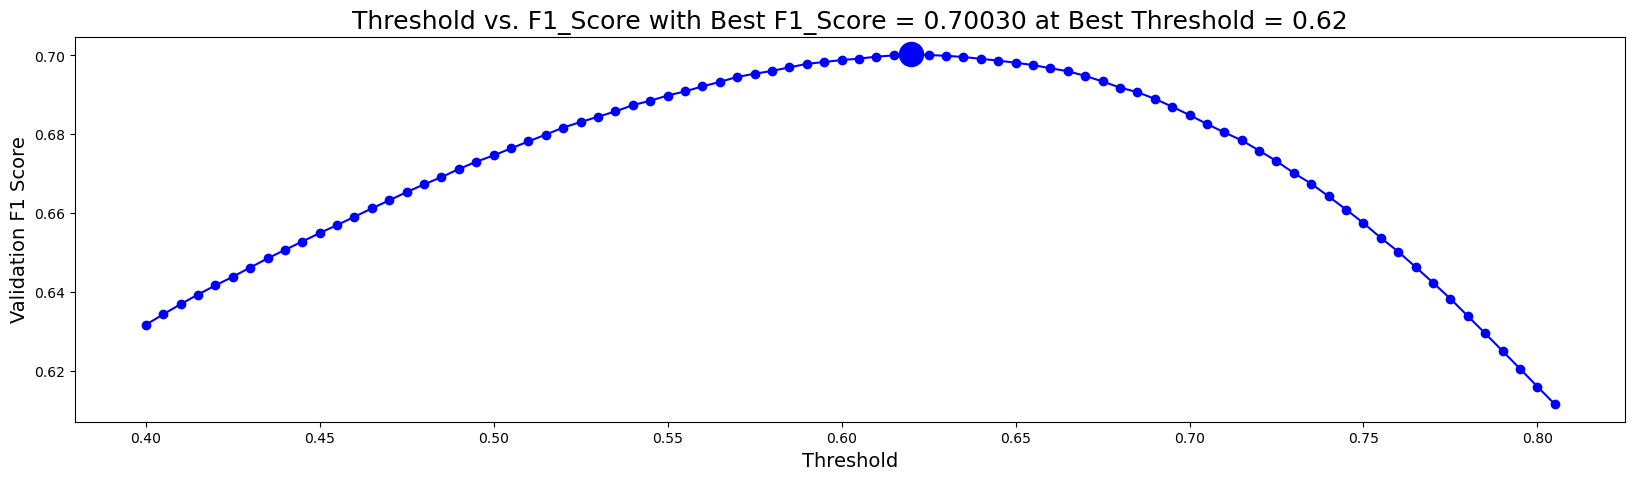

In [23]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [24]:
print('When using optimal threshold...')
for k in range(18):
    m = f1_score(true[f'meta_{k+1}'].values, (oof_xgb[f'meta_{k+1}'].values>best_threshold_xgb).astype('int'), average='macro') #Change10
    print(f'Q{k}: F1 =',m)
    
m = f1_score(true.values.reshape((-1)), (oof_xgb.values.reshape((-1))>best_threshold_xgb).astype('int'), average='macro') #Change11
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6732037803288151
Q1: F1 = 0.5115298115462626
Q2: F1 = 0.5106634048202319
Q3: F1 = 0.6844796511253243
Q4: F1 = 0.6464025114950385
Q5: F1 = 0.6506240004413942
Q6: F1 = 0.6399617875116373
Q7: F1 = 0.5759160046123137
Q8: F1 = 0.6387380197497757
Q9: F1 = 0.6001969057045338
Q10: F1 = 0.6187331897399442
Q11: F1 = 0.5151508821345984
Q12: F1 = 0.47498073354819603
Q13: F1 = 0.6428901069752841
Q14: F1 = 0.6188327969944842
Q15: F1 = 0.4955167498942816
Q16: F1 = 0.5528594570233116
Q17: F1 = 0.4881938964780805
==> Overall F1 = 0.7002997483316249


In [25]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
        print(len(importance_dict[str(t)]))
    elif t<=13: 
        importance_dict[str(t)] = joined_FEATURES2
        print(len(importance_dict[str(t)]))
    elif t<=22:
        importance_dict[str(t)] = joined_FEATURES3
        print(len(importance_dict[str(t)]))

f_save = open('model_v7/importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

1134
1134
1134
3035
3035
3035
3035
3035
3035
3035
3035
3035
3035
4151
4151
4151
4151
4151


In [26]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
        print(len(importance_dict[str(t)]))
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
        print(len(importance_dict[str(t)]))
    elif t<=22:
        importance_dict[str(t)] = FEATURES3
        print(len(importance_dict[str(t)]))

f_save = open('model_v7/importance_dict_origin.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

1134
1134
1134
2130
2130
2130
2130
2130
2130
2130
2130
2130
2130
1150
1150
1150
1150
1150
